## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
from pprint import pprint

In [8]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False

반복적으로 쓰는 함수툴

In [9]:
def plot_box(df, col_name):
    """
    주어진 데이터프레임과 열 이름에 대해 박스 플롯을 그리는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    """
    plt.figure(figsize=(7, 4))
    plt.boxplot(df[col_name], vert=False)
    plt.xlabel(col_name)
    plt.title(f'Box Plot of {col_name}')
    plt.show()

def value_counts_ratio(df, col_name, target_name='임신_성공_여부'):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 비율과 갯수, 총 갯수를 출력하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    """
    # 각 값마다 타겟 변수의 비율 계산
    value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
    
    # 각 값마다 타겟 변수의 갯수 계산
    counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)
    
    # 각 값마다 총 갯수 계산
    total_counts = df[col_name].value_counts().rename('Total_Count')
    
    # 비율과 갯수를 합침
    result = value_counts.join(counts, lsuffix='_ratio', rsuffix='_count')
    
    # 총 갯수를 합침
    result = result.join(total_counts, on=col_name)
    
    # 출력 형식 조정
    result.index.name = 'variable'
    print(f"\n{col_name}별 {target_name} 비율 및 갯수\n")
    print(result.rename(columns=lambda x: x.split('_')[0]))

def summarize_group(df, group_by_columns):
    """
    주어진 데이터프레임을 특정 열들로 그룹화하여 각 그룹의 '임신_성공_여부' 비율과 갯수를 요약하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    group_by_columns (list): 그룹화할 열 이름들의 리스트
    """
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_columns)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신_성공_여부' 변수의 '임신 성공' 비율과 갯수 계산
        success_count = group['임신_성공_여부'].value_counts().get(1, 0)
        success_ratio = success_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, success_count, success_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', "'임신_성공_여부' count", 'ratio', 'Total'])
    
    # 그룹화된 변수들의 이름을 제목행으로 출력
    print(f"Grouped by: {', '.join(group_by_columns)}")
    print()
    # 데이터프레임 출력
    print(results_df)

def plot_ratio(df, group_by_column, target_column='임신_성공_여부', success_value=1):
    """
    주어진 데이터프레임을 특정 열로 그룹화하여 각 그룹의 타겟 변수의 성공 비율을 시각화하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    group_by_column (str): 그룹화할 열 이름
    target_column (str): 타겟 변수 이름
    success_value (int): 타겟 변수의 성공을 나타내는 값
    """
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_column)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신_성공_여부' 변수의 '성공' 비율과 갯수 계산
        success_count = group[target_column].value_counts().get(success_value, 0)
        success_ratio = success_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, success_count, success_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', f"'{success_value}' count", 'ratio', 'Total'])
    
    # 그래프 크기 설정
    plt.figure(figsize=(10, 5))
    
    # 막대 그래프 생성
    ax = results_df.plot(kind='bar', x='group', y='ratio', legend=False)
    
    # 각 막대 위에 임신 성공 여부 갯수와 총 갯수 표시
    for i, (success_count, total) in enumerate(zip(results_df[f"'{success_value}' count"], results_df['Total'])):
        ax.text(i, results_df['ratio'][i], f'{success_count} ({total})', ha='center', va='bottom', fontsize=8)
    
    # 그래프 제목 및 축 레이블 설정
    ax.set_title(f'{success_value} Ratio by {group_by_column}')
    ax.set_xlabel(group_by_column)
    ax.set_ylabel(f'{success_value} Ratio')
   
    # 그래프 출력
    plt.show()

def plot_ratio_boxplot(data, column_name, target_column='임신_성공_여부'):
    """
    주어진 데이터프레임의 특정 열과 타겟 변수 간의 관계를 박스 플롯으로 시각화하는 함수.

    Parameters:
    data (pd.DataFrame): 데이터프레임
    column_name (str): 열 이름
    target_column (str): 타겟 변수 이름
    """

    # 그래프 그리기
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=column_name, y=target_column, data=data)

    # 그래프 제목 및 레이블 설정
    plt.title(f'{column_name} vs {target_column}')
    plt.xlabel(column_name)
    plt.ylabel(target_column)

    # 그래프 출력
    plt.show()

### Data Load

In [10]:
# 데이터 로드
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# 변수명에서 공백을 밑줄로 대체
train.columns = train.columns.str.replace(' ', '_')
test.columns = test.columns.str.replace(' ', '_')

# 변경된 변수명 확인
print(train.columns)

Index(['ID', '시술_시기_코드', '시술_당시_나이', '임신_시도_또는_마지막_임신_경과_연수', '시술_유형',
       '특정_시술_유형', '배란_자극_여부', '배란_유도_유형', '단일_배아_이식_여부', '착상_전_유전_검사_사용_여부',
       '착상_전_유전_진단_사용_여부', '남성_주_불임_원인', '남성_부_불임_원인', '여성_주_불임_원인',
       '여성_부_불임_원인', '부부_주_불임_원인', '부부_부_불임_원인', '불명확_불임_원인', '불임_원인_-_난관_질환',
       '불임_원인_-_남성_요인', '불임_원인_-_배란_장애', '불임_원인_-_여성_요인', '불임_원인_-_자궁경부_문제',
       '불임_원인_-_자궁내막증', '불임_원인_-_정자_농도', '불임_원인_-_정자_면역학적_요인',
       '불임_원인_-_정자_운동성', '불임_원인_-_정자_형태', '배아_생성_주요_이유', '총_시술_횟수',
       '클리닉_내_총_시술_횟수', 'IVF_시술_횟수', 'DI_시술_횟수', '총_임신_횟수', 'IVF_임신_횟수',
       'DI_임신_횟수', '총_출산_횟수', 'IVF_출산_횟수', 'DI_출산_횟수', '총_생성_배아_수',
       '미세주입된_난자_수', '미세주입에서_생성된_배아_수', '이식된_배아_수', '미세주입_배아_이식_수', '저장된_배아_수',
       '미세주입_후_저장된_배아_수', '해동된_배아_수', '해동_난자_수', '수집된_신선_난자_수', '저장된_신선_난자_수',
       '혼합된_난자_수', '파트너_정자와_혼합된_난자_수', '기증자_정자와_혼합된_난자_수', '난자_출처', '정자_출처',
       '난자_기증자_나이', '정자_기증자_나이', '동결_배아_사용_여부', '신선_배아_사용_여부', '기증_배아_사용_여부',
       '대리모_여부', 'PGD_시술_여부', 'PGS_시술_여부

In [11]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256351 entries, 0 to 256350
Data columns (total 69 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     256351 non-null  object 
 1   시술_시기_코드               256351 non-null  object 
 2   시술_당시_나이               256351 non-null  object 
 3   임신_시도_또는_마지막_임신_경과_연수  9370 non-null    float64
 4   시술_유형                  256351 non-null  object 
 5   특정_시술_유형               256349 non-null  object 
 6   배란_자극_여부               256351 non-null  int64  
 7   배란_유도_유형               256351 non-null  object 
 8   단일_배아_이식_여부            250060 non-null  float64
 9   착상_전_유전_검사_사용_여부       2718 non-null    float64
 10  착상_전_유전_진단_사용_여부       250060 non-null  float64
 11  남성_주_불임_원인             256351 non-null  int64  
 12  남성_부_불임_원인             256351 non-null  int64  
 13  여성_주_불임_원인             256351 non-null  int64  
 14  여성_부_불임_원인             256351 non-nu

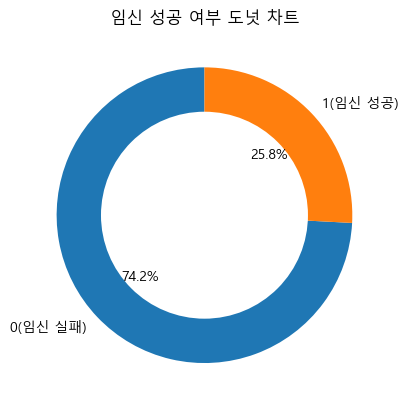

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# '임신_성공_여부' 변수의 값 개수 계산
value_counts = train['임신_성공_여부'].value_counts()

# 라벨 변경
labels = {1: '1(임신 성공)', 0: '0(임신 실패)'}
value_counts.index = value_counts.index.map(labels)

# 도넛 차트 그리기
fig, ax = plt.subplots()

# 파이 차트 그리기
wedges, texts, autotexts = ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.5))

# 도넛 차트 가운데에 원 그리기
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# 차트 제목 설정
ax.set_title('임신 성공 여부 도넛 차트')

# 차트 표시
plt.show()

## EDA

In [ ]:
# '시술_시기_코드' 변수의 값이 'TRCMWS'에 해당 안하는 데이터 추출
IVF_train = train[train['시술_시기_코드'] == 'TRCMWS'] 
IVF_test = test[test['시술_시기_코드'] == 'TRCMWS']

# 모든 값이 결측값인 변수를 제거
IVF_train = IVF_train.dropna(axis=1, how='all')
IVF_test = IVF_test.dropna(axis=1, how='all')

train = IVF_train
test = IVF_test

### 1. 시술_시기_코드

난임 시술을 받은 시기를 기준으로 코드 부여

In [14]:
value_counts_ratio(train, '시술_시기_코드')


시술_시기_코드별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
TRCMWS    0.742583  0.257417  28285  9805  38090


In [15]:
# '시술_시기_코드' 변수 제거
train = train.drop(columns=['시술_시기_코드'])
test = test.drop(columns=['시술_시기_코드'])

### 2. 시술 당시 나이

환자의 시술 당시 나이(연령대)

In [16]:
value_counts_ratio(train, '시술_당시_나이')


시술_당시_나이별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
만18-34세   0.667625  0.332375  9981.0  4969.0  14950
만35-37세   0.730547  0.269453  6309.0  2327.0   8636
만38-39세   0.788356  0.211644  4306.0  1156.0   5462
만40-42세   0.844312  0.155688  4832.0   891.0   5723
만43-44세   0.874455  0.125545  1804.0   259.0   2063
만45-50세   0.830692  0.169308   996.0   203.0   1199
알 수 없음    1.000000  0.000000    57.0     0.0     57


In [17]:
test['시술_당시_나이'].value_counts()

만18-34세    5189
만35-37세    3025
만40-42세    2051
만38-39세    1963
만43-44세     746
만45-50세     390
알 수 없음       28
Name: 시술_당시_나이, dtype: int64

### 3. 임신 시도 또는 마지막 임신 경과 일수

환자가 처음 임신을 시도한 시점 또는 마지막 임신 이후 현재까지의 경과 연수 (년 단위)

In [18]:
value_counts_ratio(train, '임신_시도_또는_마지막_임신_경과_연수')


임신_시도_또는_마지막_임신_경과_연수별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
2.0       1.000000  0.000000   1.0   0.0      1
3.0       1.000000  0.000000   1.0   0.0      1
5.0       1.000000  0.000000   3.0   0.0      3
6.0       1.000000  0.000000   2.0   0.0      2
7.0       0.000000  1.000000   0.0   1.0      1
8.0       1.000000  0.000000   4.0   0.0      4
9.0       0.777778  0.222222   7.0   2.0      9
10.0      0.805556  0.194444  29.0   7.0     36
11.0      0.629630  0.370370  17.0  10.0     27
12.0      0.733333  0.266667  22.0   8.0     30
13.0      0.900000  0.100000  36.0   4.0     40
14.0      0.821429  0.178571  23.0   5.0     28
15.0      0.821429  0.178571  23.0   5.0     28
16.0      0.777778  0.222222  14.0   4.0     18
17.0      0.769231  0.230769  10.0   3.0     13
18.0      0.500000  0.500000   3.0   3.0      6
19.0      0.600000  0.400000   6.0   4.0     10
20.0      1.000000  0.000000   7.0   0.0      

In [19]:
# 3년 단위로 범주화
bins = list(range(0, 24, 3))  # 0부터 20까지 3년 단위로 구간 생성
labels = [f'{i}-{i+2}년' for i in range(0, 21, 3)]  # 범주 레이블 생성

train['임신_시도_또는_마지막_임신_경과_연수'] = pd.cut(train['임신_시도_또는_마지막_임신_경과_연수'], bins=bins, labels=labels, right=False)
test['임신_시도_또는_마지막_임신_경과_연수'] = pd.cut(test['임신_시도_또는_마지막_임신_경과_연수'], bins=bins, labels=labels, right=False)

# 결측값을 'unknown'으로 채우기 위해 범주에 'unknown' 추가
train['임신_시도_또는_마지막_임신_경과_연수'] = train['임신_시도_또는_마지막_임신_경과_연수'].cat.add_categories(['unknown'])
test['임신_시도_또는_마지막_임신_경과_연수'] = test['임신_시도_또는_마지막_임신_경과_연수'].cat.add_categories(['unknown'])

train['임신_시도_또는_마지막_임신_경과_연수'].fillna('unknown', inplace=True)
test['임신_시도_또는_마지막_임신_경과_연수'].fillna('unknown', inplace=True)

In [20]:
value_counts_ratio(train, '임신_시도_또는_마지막_임신_경과_연수')


임신_시도_또는_마지막_임신_경과_연수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0-2년      1.000000  0.000000      1.0     0.0      1
3-5년      1.000000  0.000000      4.0     0.0      4
6-8년      0.857143  0.142857      6.0     1.0      7
9-11년     0.736111  0.263889     53.0    19.0     72
12-14년    0.826531  0.173469     81.0    17.0     98
15-17년    0.796610  0.203390     47.0    12.0     59
18-20년    0.695652  0.304348     16.0     7.0     23
unknown   0.742267  0.257733  28077.0  9749.0  37826


### 4. 시술_유형

IVF 또는 DI 시술 여부

In [21]:
value_counts_ratio(train, '시술_유형')


시술_유형별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
DI        0.862981  0.137019    718   114    832
IVF       0.739895  0.260105  27567  9691  37258


In [22]:
test['시술_유형'].value_counts()

IVF    13108
DI       284
Name: 시술_유형, dtype: int64

### 5. 특정_시술_유형

IVF – 체외 수정 (시험관 아기 시술)  
ICSI – 세포질 내 정자 주입  
IUI – 인공 수정 (자궁 내 주입)  
ICI – 자궁경부 인공 수정  
GIFT – 생식세포 나팔관 이식  
FER – 냉동 배아 이식  
Generic DI – 기증 정자 주입  
IVI – 질 내 인공 수정   
BLASTOCYST – 배반포 단계에 이식  
AH – 배아를 hatching 시켜주는 과정  
Unknown – 시술 유형 정보가 제공되지 않았거나 알 수 없음  

(*) 특수 기호의 의미  
"/" – 복합적인 시술 방법을 의미 (예: ICSI / BLASTOCYST)  
":" – 동일 시술 내 세부 조합을 의미 (예: ICSI:IVF)  

In [23]:
summarize_group(train, ['특정_시술_유형'])

Grouped by: 특정_시술_유형

                 group  '임신_성공_여부' count     ratio  Total
0           Generic DI                 2  0.090909     22
1                  ICI                 0  0.000000      1
2                 ICSI              5062  0.275828  18352
3   ICSI / BLASTOCYST                  7  0.318182     22
4            ICSI:ICSI                 5  0.007610    657
5             ICSI:IVF                26  0.203125    128
6         ICSI:Unknown                 2  0.044444     45
7                  IUI               110  0.136476    806
8                  IVF              3423  0.254915  13428
9     IVF / BLASTOCYST                 3  0.230769     13
10            IVF:ICSI                19  0.311475     61
11             IVF:IVF                 4  0.014925    268
12         IVF:Unknown                 5  0.192308     26
13                 IVI                 2  0.666667      3
14             Unknown              1135  0.266557   4258


In [24]:
test['특정_시술_유형'].value_counts()

ICSI                  6410
IVF                   4832
Unknown               1459
IUI                    280
ICSI:ICSI              214
IVF:IVF                 98
ICSI:IVF                41
ICSI:Unknown            20
IVF:ICSI                19
IVF:Unknown              8
ICSI / BLASTOCYST        5
Generic DI               4
ICSI / AH                2
Name: 특정_시술_유형, dtype: int64

In [25]:
# '특정_시술_유형' 변수의 값이 'FER' 또는 'GIFT'인 행 제거
train = train.loc[~train['특정_시술_유형'].isin(['FER', 'GIFT'])]
# test = test.loc[~test['특정_시술_유형'].isin(['FER', 'GIFT'])]

In [26]:
# 시술 유형 변환 함수
def transform_treatment(treatment):
    if isinstance(treatment, str):  # treatment가 문자열인지 확인
        if treatment.startswith("ICSI"):
            if "AH" in treatment:
                return "ICSI / AH"
            elif "BLASTOCYST" in treatment:
                return "ICSI / BLASTOCYST"
            return "ICSI"
        elif treatment.startswith("IVF"):
            if "AH" in treatment:
                return "IVF / AH"
            elif "BLASTOCYST" in treatment:
                return "IVF / BLASTOCYST"
            return "IVF"
        elif treatment == "IUI:ICI":
            return "IUI"
    return treatment  # 기타 시술은 그대로 반환

# 변환된 열 추가
train['변환된_특정_시술_유형'] = train['특정_시술_유형'].apply(transform_treatment)
test['변환된_특정_시술_유형'] = test['특정_시술_유형'].apply(transform_treatment)

In [27]:
value_counts_ratio(train, '변환된_특정_시술_유형')


변환된_특정_시술_유형별 임신_성공_여부 비율 및 갯수

                          0         1        0       1  Total
variable                                                     
Generic DI         0.909091  0.090909     20.0     2.0     22
ICI                1.000000  0.000000      1.0     0.0      1
ICSI               0.734386  0.265614  14087.0  5095.0  19182
ICSI / BLASTOCYST  0.681818  0.318182     15.0     7.0     22
IUI                0.863524  0.136476    696.0   110.0    806
IVF                0.749619  0.250381  10332.0  3451.0  13783
IVF / BLASTOCYST   0.769231  0.230769     10.0     3.0     13
IVI                0.333333  0.666667      1.0     2.0      3
Unknown            0.733443  0.266557   3123.0  1135.0   4258


In [28]:
test['변환된_특정_시술_유형'].value_counts()

ICSI                 6685
IVF                  4957
Unknown              1459
IUI                   280
ICSI / BLASTOCYST       5
Generic DI              4
ICSI / AH               2
Name: 변환된_특정_시술_유형, dtype: int64

In [29]:
# 더미 변수 생성 함수 정의
def create_dummy(x, keyword):
    if isinstance(x, str) and keyword in x:
        return 1
    else:
        return 0

# 더미 변수 생성
train['특정_시술_유형_ICSI_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'ICSI'))
train['특정_시술_유형_IVF_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'IVF'))
train['특정_시술_유형_AH_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'AH'))
train['특정_시술_유형_BLASTOCYST_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'BLASTOCYST'))

test['특정_시술_유형_ICSI_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'ICSI'))
test['특정_시술_유형_IVF_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'IVF'))
test['특정_시술_유형_AH_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'AH'))
test['특정_시술_유형_BLASTOCYST_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'BLASTOCYST'))

In [30]:
summarize_group(train, ['특정_시술_유형',
                        '특정_시술_유형_ICSI_더미',
                          '특정_시술_유형_IVF_더미',
                            '특정_시술_유형_AH_더미',
                              '특정_시술_유형_BLASTOCYST_더미'])

Grouped by: 특정_시술_유형, 특정_시술_유형_ICSI_더미, 특정_시술_유형_IVF_더미, 특정_시술_유형_AH_더미, 특정_시술_유형_BLASTOCYST_더미

                               group  '임신_성공_여부' count     ratio  Total
0           (Generic DI, 0, 0, 0, 0)                 2  0.090909     22
1                  (ICI, 0, 0, 0, 0)                 0  0.000000      1
2                 (ICSI, 1, 0, 0, 0)              5062  0.275828  18352
3   (ICSI / BLASTOCYST , 1, 0, 0, 1)                 7  0.318182     22
4            (ICSI:ICSI, 1, 0, 0, 0)                 5  0.007610    657
5             (ICSI:IVF, 1, 0, 0, 0)                26  0.203125    128
6         (ICSI:Unknown, 1, 0, 0, 0)                 2  0.044444     45
7                  (IUI, 0, 0, 0, 0)               110  0.136476    806
8                  (IVF, 0, 1, 0, 0)              3423  0.254915  13428
9     (IVF / BLASTOCYST, 0, 1, 0, 1)                 3  0.230769     13
10            (IVF:ICSI, 0, 1, 0, 0)                19  0.311475     61
11             (IVF:IVF, 0, 1, 0, 0)   

In [31]:
# '특정_시술_유형' 변수 제거
train = train.drop(columns=['특정_시술_유형'])
test = test.drop(columns=['특정_시술_유형'])

### 6. 배란_자극_여부

배란 자극 치료가 사용되었는지 여부

In [32]:
value_counts_ratio(train, '배란_자극_여부')


배란_자극_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.754272  0.245728   6974  2272   9246
1         0.738836  0.261164  21311  7533  28844


### 7. 배란_유도_유형

사용된 배란 유도 방법 유형

In [33]:
value_counts_ratio(train, '배란_유도_유형')


배란_유도_유형별 임신_성공_여부 비율 및 갯수

                   0         1      0     1  Total
variable                                          
기록되지 않은 시행  0.737240  0.262760  20973  7475  28448
알 수 없음      0.758349  0.241651   7312  2330   9642


In [34]:
test['배란_유도_유형'].value_counts()

기록되지 않은 시행    10068
알 수 없음         3324
Name: 배란_유도_유형, dtype: int64

### 8. 단일_배아_이식_여부

선택적으로 단일 배아를 이식했는지 여부

In [35]:
value_counts_ratio(train, '단일_배아_이식_여부')


단일_배아_이식_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.785785  0.214215  21371  5826  27197
1.0       0.615843  0.384157   6196  3865  10061


### 9. 착상_전_유전_검사_사용_여부

PGS(착상 전 유전 검사)가 시행되었는지 여부

In [36]:
value_counts_ratio(train, '착상_전_유전_검사_사용_여부')


착상_전_유전_검사_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1    0   1  Total
variable                                    
1.0       0.884444  0.115556  597  78    675


In [37]:
# 결측값 개수 확인
print("결측값 개수:", train['착상_전_유전_검사_사용_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['착상_전_유전_검사_사용_여부'].fillna(0, inplace=True)
test['착상_전_유전_검사_사용_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['착상_전_유전_검사_사용_여부'].isnull().sum())

결측값 개수: 37415
결측값 개수: 0


In [38]:
value_counts_ratio(train, '착상_전_유전_검사_사용_여부')


착상_전_유전_검사_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.740024  0.259976  27688  9727  37415
1.0       0.884444  0.115556    597    78    675


### 10. 착상_전_유전_진단_사용_여부

PGD(착상 전 유전 진단)가 시행되었는지 여부

In [39]:
value_counts_ratio(train, '착상_전_유전_진단_사용_여부')


착상_전_유전_진단_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.737773  0.262227  27018  9603  36621
1.0       0.861852  0.138148    549    88    637


In [40]:
summarize_group(train, ['착상_전_유전_진단_사용_여부', '착상_전_유전_검사_사용_여부'])

Grouped by: 착상_전_유전_진단_사용_여부, 착상_전_유전_검사_사용_여부

        group  '임신_성공_여부' count     ratio  Total
0  (0.0, 0.0)              9526  0.264957  35953
1  (0.0, 1.0)                77  0.115269    668
2  (1.0, 0.0)                87  0.138095    630
3  (1.0, 1.0)                 1  0.142857      7


### 11. 남성_주_불임_원인

남성의 주요 불임 원인 여부

In [41]:
value_counts_ratio(train, '남성_주_불임_원인')


남성_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.742272  0.257728  28118  9763  37881
1         0.799043  0.200957    167    42    209


### 12. 남성_부_불임_원인

남성의 부차적 불임 원인 여부

In [42]:
value_counts_ratio(train, '남성_부_불임_원인')


남성_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.742518  0.257482  28209  9782  37991
1         0.767677  0.232323     76    23     99


In [43]:
summarize_group(train, ['남성_주_불임_원인', '남성_부_불임_원인'])

Grouped by: 남성_주_불임_원인, 남성_부_불임_원인

    group  '임신_성공_여부' count     ratio  Total
0  (0, 0)              9740  0.257795  37782
1  (0, 1)                23  0.232323     99
2  (1, 0)                42  0.200957    209


### 13. 여성_주_불임_원인

여성의 주요 불임 원인 여부

In [44]:
value_counts_ratio(train, '여성_주_불임_원인')


여성_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.742287  0.257713  28103  9757  37860
1         0.791304  0.208696    182    48    230


### 14. 여성_부_불임_원인

여성의 부차적 불임 원인 여부

In [45]:
value_counts_ratio(train, '여성_부_불임_원인')


여성_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.742479  0.257521  28209  9784  37993
1         0.783505  0.216495     76    21     97


In [46]:
summarize_group(train, ['여성_주_불임_원인', '여성_부_불임_원인'])

Grouped by: 여성_주_불임_원인, 여성_부_불임_원인

    group  '임신_성공_여부' count     ratio  Total
0  (0, 0)              9736  0.257818  37763
1  (0, 1)                21  0.216495     97
2  (1, 0)                48  0.208696    230


In [47]:
summarize_group(train, ['남성_주_불임_원인', '남성_부_불임_원인', '여성_주_불임_원인', '여성_부_불임_원인'])

Grouped by: 남성_주_불임_원인, 남성_부_불임_원인, 여성_주_불임_원인, 여성_부_불임_원인

          group  '임신_성공_여부' count     ratio  Total
0  (0, 0, 0, 0)              9736  0.257818  37763
1  (0, 0, 0, 1)                 1  0.200000      5
2  (0, 0, 1, 0)                 3  0.214286     14
3  (0, 1, 0, 1)                13  0.200000     65
4  (0, 1, 1, 0)                10  0.294118     34
5  (1, 0, 0, 1)                 7  0.259259     27
6  (1, 0, 1, 0)                35  0.192308    182


### 15. 부부_주_불임_원인

부부의 주요 불임 원인 여부

In [48]:
value_counts_ratio(train, '부부_주_불임_원인')


부부_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.742280  0.257720  28099  9756  37855
1         0.791489  0.208511    186    49    235


### 16. 부부_부_불임_원인

부부의 부차적 불임 원인 여부

In [49]:
value_counts_ratio(train, '부부_부_불임_원인')


부부_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.742523  0.257477  28227  9788  38015
1         0.773333  0.226667     58    17     75


In [50]:
summarize_group(train, ['부부_주_불임_원인', '부부_부_불임_원인'])

Grouped by: 부부_주_불임_원인, 부부_부_불임_원인

    group  '임신_성공_여부' count     ratio  Total
0  (0, 0)              9739  0.257782  37780
1  (0, 1)                17  0.226667     75
2  (1, 0)                49  0.208511    235


In [51]:
summarize_group(train, ['남성_주_불임_원인', '남성_부_불임_원인'
                        , '여성_주_불임_원인', '여성_부_불임_원인'
                        , '부부_주_불임_원인', '부부_부_불임_원인'])

Grouped by: 남성_주_불임_원인, 남성_부_불임_원인, 여성_주_불임_원인, 여성_부_불임_원인, 부부_주_불임_원인, 부부_부_불임_원인

                 group  '임신_성공_여부' count     ratio  Total
0   (0, 0, 0, 0, 0, 0)              9736  0.257818  37763
1   (0, 0, 0, 1, 0, 0)                 1  0.250000      4
2   (0, 0, 0, 1, 0, 1)                 0  0.000000      1
3   (0, 0, 1, 0, 0, 0)                 2  0.200000     10
4   (0, 0, 1, 0, 1, 0)                 1  0.250000      4
5   (0, 1, 0, 1, 0, 1)                12  0.200000     60
6   (0, 1, 0, 1, 1, 0)                 1  0.200000      5
7   (0, 1, 1, 0, 0, 1)                 5  0.384615     13
8   (0, 1, 1, 0, 1, 0)                 5  0.238095     21
9   (1, 0, 0, 1, 0, 0)                 0  0.000000      1
10  (1, 0, 0, 1, 1, 0)                 7  0.269231     26
11  (1, 0, 1, 0, 0, 0)                 0  0.000000      2
12  (1, 0, 1, 0, 0, 1)                 0  0.000000      1
13  (1, 0, 1, 0, 1, 0)                35  0.195531    179


### 17. 불명확_불임_원인

불명의 원인으로 인한 불임 여부

In [52]:
value_counts_ratio(train, '불명확_불임_원인')


불명확_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.742079  0.257921  21009  7302  28311
1         0.744043  0.255957   7276  2503   9779


### 18. 불임_원인_-_난관_질환

난관 이상으로 인한 불임 여부

In [53]:
value_counts_ratio(train, '불임_원인_-_난관_질환')


불임_원인_-_난관_질환별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.743792  0.256208  24830  8553  33383
1         0.734013  0.265987   3455  1252   4707


### 19. 불임_원인_-_남성_요인

남성 요인으로 인한 불임 여부

In [54]:
value_counts_ratio(train, '불임_원인_-_남성_요인')


불임_원인_-_남성_요인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.761364  0.238636  18626  5838  24464
1         0.708865  0.291135   9659  3967  13626


### 20. 불임_원인_-_배란_장애

배란 장애로 인한 불임 여부

In [55]:
value_counts_ratio(train, '불임_원인_-_배란_장애')


불임_원인_-_배란_장애별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.748456  0.251544  24836  8347  33183
1         0.702873  0.297127   3449  1458   4907


### 21. 불임_원인_-_여성_요인

여성 요인으로 인한 불임 여부

In [56]:
value_counts_ratio(train, '불임_원인_-_여성_요인')


불임_원인_-_여성_요인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.742583  0.257417  28285  9805  38090


In [57]:
test['불임_원인_-_여성_요인'].value_counts()

0    13392
Name: 불임_원인_-_여성_요인, dtype: int64

In [58]:
# '불임_원인_-_여성_요인' 변수 제거
train = train.drop(columns=['불임_원인_-_여성_요인'])
test = test.drop(columns=['불임_원인_-_여성_요인'])

### 22. 불임_원인_-_자궁경부_문제

자궁경부 이상으로 인한 불임 여부

In [59]:
value_counts_ratio(train, '불임_원인_-_자궁경부_문제')


불임_원인_-_자궁경부_문제별 임신_성공_여부 비율 및 갯수

                0        1        0       1  Total
variable                                          
0         0.74257  0.25743  28283.0  9805.0  38088
1         1.00000  0.00000      2.0     0.0      2


### 23. 불임_원인_-_자궁내막증

자궁내막증으로 인한 불임 여부

In [60]:
value_counts_ratio(train, '불임_원인_-_자궁내막증')


불임_원인_-_자궁내막증별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.742089  0.257911  26313  9145  35458
1         0.749240  0.250760   1972   660   2632


### 24. 불임_원인_-_정자_농도

파트너의 정자 농도 문제 여부

In [61]:
value_counts_ratio(train, '불임_원인_-_정자_농도')


불임_원인_-_정자_농도별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.742635  0.257365  28284  9802  38086
1         0.250000  0.750000      1     3      4


### 25. 불임_원인_-_정자_면역학적_요인

파트너의 정자 면역 관련 문제 여부

In [62]:
value_counts_ratio(train, '불임_원인_-_정자_면역학적_요인')


불임_원인_-_정자_면역학적_요인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.742583  0.257417  28285  9805  38090


In [63]:
test['불임_원인_-_정자_면역학적_요인'].value_counts()

0    13392
Name: 불임_원인_-_정자_면역학적_요인, dtype: int64

In [64]:
# '불임_원인_-_정자_면역학적_요인' 변수 제거
train = train.drop(columns=['불임_원인_-_정자_면역학적_요인'])
test = test.drop(columns=['불임_원인_-_정자_면역학적_요인'])

### 26. 불임_원인_-_정자_운동성

파트너의 정자 운동성 문제 여부

In [65]:
value_counts_ratio(train, '불임_원인_-_정자_운동성')


불임_원인_-_정자_운동성별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.742583  0.257417  28285  9805  38090


In [66]:
# '불임_원인_-_정자_운동성' 변수 제거
train = train.drop(columns=['불임_원인_-_정자_운동성'])
test = test.drop(columns=['불임_원인_-_정자_운동성'])

### 27. 불임_원인_-_정자_형태

파트너의 정자 형태 문제 여부

In [67]:
value_counts_ratio(train, '불임_원인_-_정자_형태')


불임_원인_-_정자_형태별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.742602  0.257398  28282  9803  38085
1         0.600000  0.400000      3     2      5


### 28. 배아_생성_주요_이유

배아 생성의 주된 목적(시술, 보관 등)

In [68]:
value_counts_ratio(train, '배아_생성_주요_이유')


배아_생성_주요_이유별 임신_성공_여부 비율 및 갯수

                            0         1        0       1  Total
variable                                                       
기증용                  1.000000  0.000000    211.0     0.0    211
기증용, 난자 저장용          1.000000  0.000000     12.0     0.0     12
기증용, 배아 저장용          1.000000  0.000000     38.0     0.0     38
기증용, 배아 저장용, 현재 시술용  0.666667  0.333333      2.0     1.0      3
기증용, 현재 시술용          0.651111  0.348889    293.0   157.0    450
난자 저장용               1.000000  0.000000    438.0     0.0    438
난자 저장용, 배아 저장용, 연구용  1.000000  0.000000      1.0     0.0      1
배아 저장용               0.999291  0.000709   2818.0     2.0   2820
배아 저장용, 현재 시술용       0.538462  0.461538      7.0     6.0     13
현재 시술용               0.713723  0.286277  23747.0  9525.0  33272


In [69]:
# '연구용'이라는 값이 포함된 행 삭제
train = train[~train['배아_생성_주요_이유'].str.contains('연구용', na=False)]
# test = test[~test['배아_생성_주요_이유'].str.contains('연구용', na=False)]

In [70]:
value_counts_ratio(train, '배아_생성_주요_이유')


배아_생성_주요_이유별 임신_성공_여부 비율 및 갯수

                            0         1        0       1  Total
variable                                                       
기증용                  1.000000  0.000000    211.0     0.0    211
기증용, 난자 저장용          1.000000  0.000000     12.0     0.0     12
기증용, 배아 저장용          1.000000  0.000000     38.0     0.0     38
기증용, 배아 저장용, 현재 시술용  0.666667  0.333333      2.0     1.0      3
기증용, 현재 시술용          0.651111  0.348889    293.0   157.0    450
난자 저장용               1.000000  0.000000    438.0     0.0    438
배아 저장용               0.999291  0.000709   2818.0     2.0   2820
배아 저장용, 현재 시술용       0.538462  0.461538      7.0     6.0     13
현재 시술용               0.713723  0.286277  23747.0  9525.0  33272


In [71]:
test['배아_생성_주요_이유'].value_counts()

현재 시술용            11713
배아 저장용              987
기증용, 현재 시술용         165
난자 저장용              151
기증용                  69
기증용, 배아 저장용          17
기증용, 난자 저장용           3
배아 저장용, 현재 시술용        2
난자 저장용, 배아 저장용        1
Name: 배아_생성_주요_이유, dtype: int64

In [72]:
print("결측값 개수:", train['배아_생성_주요_이유'].isnull().sum())

train['배아_생성_주요_이유'].fillna('unknown', inplace=True)
test['배아_생성_주요_이유'].fillna('unknown', inplace=True)

print("결측값 개수:", train['배아_생성_주요_이유'].isnull().sum())

결측값 개수: 832
결측값 개수: 0


In [73]:
# '현재 시술용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_현재시술용'] = train['배아_생성_주요_이유'].str.contains('현재 시술용').astype(int)
test['배아_생성_주요_이유_현재시술용'] = test['배아_생성_주요_이유'].str.contains('현재 시술용').astype(int)

In [74]:
# '기증용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_기증용'] = train['배아_생성_주요_이유'].str.contains('기증용').astype(int)
test['배아_생성_주요_이유_기증용'] = test['배아_생성_주요_이유'].str.contains('기증용').astype(int)

In [75]:
# '난자 저장용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_난자저장용'] = train['배아_생성_주요_이유'].str.contains('난자 저장용').astype(int)
test['배아_생성_주요_이유_난자저장용'] = test['배아_생성_주요_이유'].str.contains('난자 저장용').astype(int)

In [76]:
# '배아 저장용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_배아저장용'] = train['배아_생성_주요_이유'].str.contains('배아 저장용').astype(int)
test['배아_생성_주요_이유_배아저장용'] = test['배아_생성_주요_이유'].str.contains('배아 저장용').astype(int)

In [77]:
summarize_group(train, [
    # '배아_생성_주요_이유',
    '배아_생성_주요_이유_현재시술용',
    '배아_생성_주요_이유_기증용',
    '배아_생성_주요_이유_난자저장용',
    '배아_생성_주요_이유_배아저장용'
                        ])

Grouped by: 배아_생성_주요_이유_현재시술용, 배아_생성_주요_이유_기증용, 배아_생성_주요_이유_난자저장용, 배아_생성_주요_이유_배아저장용

          group  '임신_성공_여부' count     ratio  Total
0  (0, 0, 0, 0)               114  0.137019    832
1  (0, 0, 0, 1)                 2  0.000709   2820
2  (0, 0, 1, 0)                 0  0.000000    438
3  (0, 1, 0, 0)                 0  0.000000    211
4  (0, 1, 0, 1)                 0  0.000000     38
5  (0, 1, 1, 0)                 0  0.000000     12
6  (1, 0, 0, 0)              9525  0.286277  33272
7  (1, 0, 0, 1)                 6  0.461538     13
8  (1, 1, 0, 0)               157  0.348889    450
9  (1, 1, 0, 1)                 1  0.333333      3


In [78]:
value_counts_ratio(train, '배아_생성_주요_이유_현재시술용')


배아_생성_주요_이유_현재시술용별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.973339  0.026661   4235   116   4351
1         0.712816  0.287184  24049  9689  33738


In [79]:
# # 변수 제거
# train = train.drop(columns=['배아_생성_주요_이유'])
# test = test.drop(columns=['배아_생성_주요_이유'])

### 29. 총_시술_횟수

IVF 및 DI 포함한 전체 시술 횟수

In [80]:
value_counts_ratio(train, '총_시술_횟수')


총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.714796  0.285204  10802  4310  15112
1회        0.751605  0.248395   6088  2012   8100
2회        0.754421  0.245579   4181  1361   5542
3회        0.759887  0.240113   2690   850   3540
4회        0.773022  0.226978   1788   525   2313
5회        0.763253  0.236747   1051   326   1377
6회 이상     0.800000  0.200000   1684   421   2105


In [81]:
test['총_시술_횟수'].value_counts()

0회       5290
1회       2835
2회       1960
3회       1264
4회        794
6회 이상     762
5회        487
Name: 총_시술_횟수, dtype: int64

In [82]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['총_시술_횟수'] = train['총_시술_횟수'].map(mapping)
test['총_시술_횟수'] = test['총_시술_횟수'].map(mapping)

value_counts_ratio(train, '총_시술_횟수')


총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.714796  0.285204  10802  4310  15112
1         0.751605  0.248395   6088  2012   8100
2         0.754421  0.245579   4181  1361   5542
3         0.759887  0.240113   2690   850   3540
4         0.773022  0.226978   1788   525   2313
5         0.763253  0.236747   1051   326   1377
6         0.800000  0.200000   1684   421   2105


### 30. 클리닉_내_총_시술_횟수

특정 클리닉에서 받은 IVF 및 DI 시술 횟수

In [83]:
value_counts_ratio(train, '클리닉_내_총_시술_횟수')


클리닉_내_총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.721841  0.278159  13375  5154  18529
1회        0.755371  0.244629   6469  2095   8564
2회        0.763450  0.236550   3789  1174   4963
3회        0.757520  0.242480   2065   661   2726
4회        0.784861  0.215139   1182   324   1506
5회        0.771753  0.228247    612   181    793
6회 이상     0.785714  0.214286    792   216   1008


In [84]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['클리닉_내_총_시술_횟수'] = train['클리닉_내_총_시술_횟수'].map(mapping)
test['클리닉_내_총_시술_횟수'] = test['클리닉_내_총_시술_횟수'].map(mapping)

value_counts_ratio(train, '클리닉_내_총_시술_횟수')


클리닉_내_총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.721841  0.278159  13375  5154  18529
1         0.755371  0.244629   6469  2095   8564
2         0.763450  0.236550   3789  1174   4963
3         0.757520  0.242480   2065   661   2726
4         0.784861  0.215139   1182   324   1506
5         0.771753  0.228247    612   181    793
6         0.785714  0.214286    792   216   1008


### 31. IVF_시술_횟수

이전에 수행된 IVF 시술 횟수

In [85]:
value_counts_ratio(train, 'IVF_시술_횟수')


IVF_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.718381  0.281619  11502  4509  16011
1회        0.748468  0.251532   6228  2093   8321
2회        0.753336  0.246664   4178  1368   5546
3회        0.760313  0.239687   2525   796   3321
4회        0.771388  0.228612   1623   481   2104
5회        0.770642  0.229358    924   275   1199
6회 이상     0.821676  0.178324   1304   283   1587


In [86]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['IVF_시술_횟수'] = train['IVF_시술_횟수'].map(mapping)
test['IVF_시술_횟수'] = test['IVF_시술_횟수'].map(mapping)

value_counts_ratio(train, 'IVF_시술_횟수')


IVF_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.718381  0.281619  11502  4509  16011
1         0.748468  0.251532   6228  2093   8321
2         0.753336  0.246664   4178  1368   5546
3         0.760313  0.239687   2525   796   3321
4         0.771388  0.228612   1623   481   2104
5         0.770642  0.229358    924   275   1199
6         0.821676  0.178324   1304   283   1587


### 32. DI_시술_횟수

이전에 수행된 DI 시술 횟수

In [87]:
value_counts_ratio(train, 'DI_시술_횟수')


DI_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.741851  0.258149  26763  9313  36076
1회        0.784897  0.215103    343    94    437
2회        0.743056  0.256944    321   111    432
3회        0.753012  0.246988    375   123    498
4회        0.739837  0.260163    182    64    246
5회        0.793548  0.206452    123    32    155
6회 이상     0.722449  0.277551    177    68    245


In [88]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['DI_시술_횟수'] = train['DI_시술_횟수'].map(mapping)
test['DI_시술_횟수'] = test['DI_시술_횟수'].map(mapping)

value_counts_ratio(train, 'DI_시술_횟수')


DI_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.741851  0.258149  26763  9313  36076
1         0.784897  0.215103    343    94    437
2         0.743056  0.256944    321   111    432
3         0.753012  0.246988    375   123    498
4         0.739837  0.260163    182    64    246
5         0.793548  0.206452    123    32    155
6         0.722449  0.277551    177    68    245


### 33. 총_임신_횟수

IVF 및 DI 포함한 총 임신 횟수

In [89]:
value_counts_ratio(train, '총_임신_횟수')


총_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0회        0.746036  0.253964  22819.0  7768.0  30587
1회        0.727416  0.272584   4622.0  1732.0   6354
2회        0.734064  0.265936    737.0   267.0   1004
3회        0.736000  0.264000     92.0    33.0    125
4회        0.777778  0.222222     14.0     4.0     18
5회        0.000000  1.000000      0.0     1.0      1


In [90]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['총_임신_횟수'] = train['총_임신_횟수'].map(mapping)
test['총_임신_횟수'] = test['총_임신_횟수'].map(mapping)

value_counts_ratio(train, '총_임신_횟수')


총_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.746036  0.253964  22819.0  7768.0  30587
1         0.727416  0.272584   4622.0  1732.0   6354
2         0.734064  0.265936    737.0   267.0   1004
3         0.736000  0.264000     92.0    33.0    125
4         0.777778  0.222222     14.0     4.0     18
5         0.000000  1.000000      0.0     1.0      1


### 34. IVF_임신_횟수

IVF 시술로 인한 임신 횟수

In [91]:
value_counts_ratio(train, 'IVF_임신_횟수')


IVF_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0회        0.746279  0.253721  23116.0  7859.0  30975
1회        0.725004  0.274996   4387.0  1664.0   6051
2회        0.735889  0.264111    691.0   248.0    939
3회        0.736364  0.263636     81.0    29.0    110
4회        0.692308  0.307692      9.0     4.0     13
5회        0.000000  1.000000      0.0     1.0      1


In [92]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['IVF_임신_횟수'] = train['IVF_임신_횟수'].map(mapping)
test['IVF_임신_횟수'] = test['IVF_임신_횟수'].map(mapping)

value_counts_ratio(train, 'IVF_임신_횟수')


IVF_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.746279  0.253721  23116.0  7859.0  30975
1         0.725004  0.274996   4387.0  1664.0   6051
2         0.735889  0.264111    691.0   248.0    939
3         0.736364  0.263636     81.0    29.0    110
4         0.692308  0.307692      9.0     4.0     13
5         0.000000  1.000000      0.0     1.0      1


### 35. DI_임신_횟수

DI 시술로 인한 임신 횟수

In [93]:
value_counts_ratio(train, 'DI_임신_횟수')


DI_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0회        0.742322  0.257678  27964.0  9707.0  37671
1회        0.769014  0.230986    273.0    82.0    355
2회        0.755102  0.244898     37.0    12.0     49
3회        0.636364  0.363636      7.0     4.0     11
4회        1.000000  0.000000      3.0     0.0      3


In [94]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5
}

# 숫자로 변환
train['DI_임신_횟수'] = train['DI_임신_횟수'].map(mapping)
test['DI_임신_횟수'] = test['DI_임신_횟수'].map(mapping)

value_counts_ratio(train, 'DI_임신_횟수')


DI_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.742322  0.257678  27964.0  9707.0  37671
1         0.769014  0.230986    273.0    82.0    355
2         0.755102  0.244898     37.0    12.0     49
3         0.636364  0.363636      7.0     4.0     11
4         1.000000  0.000000      3.0     0.0      3


### 36. 총_출산_횟수

IVF 및 DI 시술로 출산한 횟수

In [95]:
value_counts_ratio(train, '총_출산_횟수')


총_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0회        0.745969  0.254031  24194.0  8239.0  32433
1회        0.724441  0.275559   3791.0  1442.0   5233
2회        0.711340  0.288660    276.0   112.0    388
3회        0.647059  0.352941     22.0    12.0     34
4회        1.000000  0.000000      1.0     0.0      1


In [96]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['총_출산_횟수'] = train['총_출산_횟수'].map(mapping)
test['총_출산_횟수'] = test['총_출산_횟수'].map(mapping)

value_counts_ratio(train, '총_출산_횟수')


총_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.745969  0.254031  24194.0  8239.0  32433
1         0.724441  0.275559   3791.0  1442.0   5233
2         0.711340  0.288660    276.0   112.0    388
3         0.647059  0.352941     22.0    12.0     34
4         1.000000  0.000000      1.0     0.0      1


### 37. IVF_출산_횟수

IVF 시술로 출산한 횟수

In [97]:
value_counts_ratio(train, 'IVF_출산_횟수')


IVF_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0회        0.746083  0.253917  24426.0  8313.0  32739
1회        0.722379  0.277621   3583.0  1377.0   4960
2회        0.712329  0.287671    260.0   105.0    365
3회        0.583333  0.416667     14.0    10.0     24
4회        1.000000  0.000000      1.0     0.0      1


In [98]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5
}

# 숫자로 변환
train['IVF_출산_횟수'] = train['IVF_출산_횟수'].map(mapping)
test['IVF_출산_횟수'] = test['IVF_출산_횟수'].map(mapping)

value_counts_ratio(train, 'IVF_출산_횟수')


IVF_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.746083  0.253917  24426.0  8313.0  32739
1         0.722379  0.277621   3583.0  1377.0   4960
2         0.712329  0.287671    260.0   105.0    365
3         0.583333  0.416667     14.0    10.0     24
4         1.000000  0.000000      1.0     0.0      1


In [99]:
test['IVF_출산_횟수'].value_counts()

0    11553
1     1713
2      116
3        9
4        1
Name: IVF_출산_횟수, dtype: int64

### 38. DI_출산_횟수

DI 시술로 출산한 횟수

In [100]:
value_counts_ratio(train, 'DI_출산_횟수')


DI_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.742474  0.257526  28044  9727  37771
1회        0.752542  0.247458    222    73    295
2회        0.800000  0.200000     12     3     15
3회        0.750000  0.250000      6     2      8


In [101]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5
}

# 숫자로 변환
train['DI_출산_횟수'] = train['DI_출산_횟수'].map(mapping)
test['DI_출산_횟수'] = test['DI_출산_횟수'].map(mapping)

value_counts_ratio(train, 'DI_출산_횟수')


DI_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.742474  0.257526  28044  9727  37771
1         0.752542  0.247458    222    73    295
2         0.800000  0.200000     12     3     15
3         0.750000  0.250000      6     2      8


In [102]:
test['DI_출산_횟수'].value_counts()

0    13286
1      101
2        4
3        1
Name: DI_출산_횟수, dtype: int64

In [103]:
# # 모든 행과 열을 다 보이게 설정
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [104]:
# summarize_group(train, ['IVF_시술_횟수', 'IVF_임신_횟수', 'IVF_출산_횟수'])

In [105]:
# 주요 비율 계산 (train 데이터프레임)
train['IVF_임신_시술_비율'] = np.where(train['IVF_시술_횟수'] > 0, train['IVF_임신_횟수'] / train['IVF_시술_횟수'], 0)
train['IVF_출산_임신_비율'] = np.where(train['IVF_임신_횟수'] > 0, train['IVF_출산_횟수'] / train['IVF_임신_횟수'], 0)

train['DI_임신_시술_비율'] = np.where(train['DI_시술_횟수'] > 0, train['DI_임신_횟수'] / train['DI_시술_횟수'], 0)
train['DI_출산_임신_비율'] = np.where(train['DI_임신_횟수'] > 0, train['DI_출산_횟수'] / train['DI_임신_횟수'], 0)

# 성공률 계산
train['임신_성공률'] = np.where(train['총_시술_횟수'] > 0, train['총_임신_횟수'] / train['총_시술_횟수'], 0)
train['출산_성공률'] = np.where(train['총_임신_횟수'] > 0, train['총_출산_횟수'] / train['총_임신_횟수'], 0)

# 주요 비율 계산 (test 데이터프레임)
test['IVF_임신_시술_비율'] = np.where(test['IVF_시술_횟수'] > 0, test['IVF_임신_횟수'] / test['IVF_시술_횟수'], 0)
test['IVF_출산_임신_비율'] = np.where(test['IVF_임신_횟수'] > 0, test['IVF_출산_횟수'] / test['IVF_임신_횟수'], 0)

test['DI_임신_시술_비율'] = np.where(test['DI_시술_횟수'] > 0, test['DI_임신_횟수'] / test['DI_시술_횟수'], 0)
test['DI_출산_임신_비율'] = np.where(test['DI_임신_횟수'] > 0, test['DI_출산_횟수'] / test['DI_임신_횟수'], 0)

# 성공률 계산
test['임신_성공률'] = np.where(test['총_시술_횟수'] > 0, test['총_임신_횟수'] / test['총_시술_횟수'], 0)
test['출산_성공률'] = np.where(test['총_임신_횟수'] > 0, test['총_출산_횟수'] / test['총_임신_횟수'], 0)

### 39. 총_생성_배아_수

해당 시술에서 생성된 배아의 총 개수

In [106]:
value_counts_ratio(train, '총_생성_배아_수')


총_생성_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.809691  0.190309  6684.0  1571.0   8255
1.0       0.910008  0.089992  2164.0   214.0   2378
2.0       0.820668  0.179332  2311.0   505.0   2816
3.0       0.763057  0.236943  2396.0   744.0   3140
4.0       0.714286  0.285714  2265.0   906.0   3171
5.0       0.699306  0.300694  2014.0   866.0   2880
6.0       0.683729  0.316271  1870.0   865.0   2735
7.0       0.665657  0.334343  1539.0   773.0   2312
8.0       0.647239  0.352761  1266.0   690.0   1956
9.0       0.662977  0.337023  1078.0   548.0   1626
10.0      0.658288  0.341712   838.0   435.0   1273
11.0      0.643822  0.356178   667.0   369.0   1036
12.0      0.655006  0.344994   543.0   286.0    829
13.0      0.633028  0.366972   414.0   240.0    654
14.0      0.658103  0.341897   333.0   173.0    506
15.0      0.658416  0.341584   266.0   138.0    404
16.0      0.623762  0.376238   189

### 40. 미세주입된_난자_수

정자 미세주입(ICSI)으로 처리된 난자의 수

In [107]:
value_counts_ratio(train, '미세주입된_난자_수')


미세주입된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.748305  0.251695  14128.0  4752.0  18880
1.0       0.941904  0.058096    762.0    47.0    809
2.0       0.878431  0.121569    896.0   124.0   1020
3.0       0.841443  0.158557   1003.0   189.0   1192
4.0       0.795172  0.204828   1153.0   297.0   1450
5.0       0.744141  0.255859   1143.0   393.0   1536
6.0       0.720721  0.279279   1200.0   465.0   1665
7.0       0.721259  0.278741   1123.0   434.0   1557
8.0       0.695312  0.304688    979.0   429.0   1408
9.0       0.681090  0.318910    850.0   398.0   1248
10.0      0.661150  0.338850    759.0   389.0   1148
11.0      0.624350  0.375650    600.0   361.0    961
12.0      0.676329  0.323671    560.0   268.0    828
13.0      0.624269  0.375731    427.0   257.0    684
14.0      0.689408  0.310592    384.0   173.0    557
15.0      0.665188  0.334812    300.0   151.0    451
16.0      0.626

### 41. 미세주입에서_생성된_배아_수

ICSI를 통해 생성된 배아의 수

In [108]:
value_counts_ratio(train, '미세주입에서_생성된_배아_수')


미세주입에서_생성된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.756779  0.243221  14792.0  4754.0  19546
1.0       0.911873  0.088127   1490.0   144.0   1634
2.0       0.815131  0.184869   1530.0   347.0   1877
3.0       0.754514  0.245486   1546.0   503.0   2049
4.0       0.707375  0.292625   1477.0   611.0   2088
5.0       0.697521  0.302479   1266.0   549.0   1815
6.0       0.682270  0.317730   1166.0   543.0   1709
7.0       0.662181  0.337819    935.0   477.0   1412
8.0       0.646801  0.353199    738.0   403.0   1141
9.0       0.640745  0.359255    585.0   328.0    913
10.0      0.650289  0.349711    450.0   242.0    692
11.0      0.624555  0.375445    351.0   211.0    562
12.0      0.665179  0.334821    298.0   150.0    448
13.0      0.640000  0.360000    224.0   126.0    350
14.0      0.662698  0.337302    167.0    85.0    252
15.0      0.703518  0.296482    140.0    59.0    199
16.0      

### 42. 이식된_배아_수

이식된 배아의 총 수

In [109]:
value_counts_ratio(train, '이식된_배아_수')


이식된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.998890  0.001110   7201     8   7209
1.0       0.665589  0.334411  10298  5174  15472
2.0       0.679400  0.320600   9195  4339  13534
3.0       0.836852  0.163148    872   170   1042


### 43. 미세주입_배아_이식_수

ICSI 배아 중 이식된 배아의 수

In [110]:
value_counts_ratio(train, '미세주입_배아_이식_수')


미세주입_배아_이식_수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.786988  0.213012  16995  4600  21595
1.0       0.654439  0.345561   5013  2647   7660
2.0       0.682578  0.317422   5062  2354   7416
3.0       0.846416  0.153584    496    90    586


### 44. 저장된_배아_수

환자를 위해 저장된 배아의 수

In [111]:
value_counts_ratio(train, '저장된_배아_수')


저장된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.772534  0.227466  17973.0  5292.0  23265
1.0       0.681309  0.318691   2435.0  1139.0   3574
2.0       0.649922  0.350078   2096.0  1129.0   3225
3.0       0.665632  0.334368   1501.0   754.0   2255
4.0       0.676357  0.323643   1047.0   501.0   1548
5.0       0.675377  0.324623    672.0   323.0    995
6.0       0.691563  0.308437    500.0   223.0    723
7.0       0.742152  0.257848    331.0   115.0    446
8.0       0.741722  0.258278    224.0    78.0    302
9.0       0.762846  0.237154    193.0    60.0    253
10.0      0.835227  0.164773    147.0    29.0    176
11.0      0.841667  0.158333    101.0    19.0    120
12.0      0.875000  0.125000     77.0    11.0     88
13.0      0.870968  0.129032     54.0     8.0     62
14.0      0.891304  0.108696     41.0     5.0     46
15.0      0.945946  0.054054     35.0     2.0     37
16.0      0.95833

### 45. 미세주입_후_저장된_배아_수

ICSI 처리된 배아 중 저장된 배아의 수

In [112]:
value_counts_ratio(train, '미세주입_후_저장된_배아_수')


미세주입_후_저장된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.753827  0.246173  22161.0  7237.0  29398
1.0       0.694708  0.305292   1536.0   675.0   2211
2.0       0.639504  0.360496   1185.0   668.0   1853
3.0       0.660302  0.339698    830.0   427.0   1257
4.0       0.674473  0.325527    576.0   278.0    854
5.0       0.684783  0.315217    378.0   174.0    552
6.0       0.685237  0.314763    246.0   113.0    359
7.0       0.815166  0.184834    172.0    39.0    211
8.0       0.769231  0.230769    100.0    30.0    130
9.0       0.785714  0.214286     99.0    27.0    126
10.0      0.901235  0.098765     73.0     8.0     81
11.0      0.869565  0.130435     40.0     6.0     46
12.0      0.900000  0.100000     36.0     4.0     40
13.0      0.935484  0.064516     29.0     2.0     31
14.0      0.913043  0.086957     21.0     2.0     23
15.0      1.000000  0.000000     19.0     0.0     19
16.0      

### 46. 해동된_배아_수

동결 해동된 배아의 수

In [113]:
value_counts_ratio(train, '해동된_배아_수')


해동된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.739853  0.260147  23076.0  8114.0  31190
1.0       0.761563  0.238437   1910.0   598.0   2508
2.0       0.720307  0.279693   1316.0   511.0   1827
3.0       0.734694  0.265306    468.0   169.0    637
4.0       0.737127  0.262873    272.0    97.0    369
5.0       0.715736  0.284264    141.0    56.0    197
6.0       0.754098  0.245902    138.0    45.0    183
7.0       0.701299  0.298701     54.0    23.0     77
8.0       0.698795  0.301205     58.0    25.0     83
9.0       0.788462  0.211538     41.0    11.0     52
10.0      0.738095  0.261905     31.0    11.0     42
11.0      0.625000  0.375000     10.0     6.0     16
12.0      0.730769  0.269231     19.0     7.0     26
13.0      0.444444  0.555556      4.0     5.0      9
14.0      0.750000  0.250000      9.0     3.0     12
15.0      0.800000  0.200000      4.0     1.0      5
16.0      0.12500

### 47. 해동_난자_수

동결 해동된 난자의 수

In [114]:
value_counts_ratio(train, '해동_난자_수')


해동_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.739367  0.260633  27293.0  9621.0  36914
1.0       1.000000  0.000000      2.0     0.0      2
2.0       1.000000  0.000000     13.0     0.0     13
3.0       0.875000  0.125000      7.0     1.0      8
4.0       0.925926  0.074074     25.0     2.0     27
5.0       0.863636  0.136364     19.0     3.0     22
6.0       0.790323  0.209677     49.0    13.0     62
7.0       0.685714  0.314286     24.0    11.0     35
8.0       0.821429  0.178571     46.0    10.0     56
9.0       0.894737  0.105263     17.0     2.0     19
10.0      0.818182  0.181818     18.0     4.0     22
11.0      0.764706  0.235294     13.0     4.0     17
12.0      0.526316  0.473684     10.0     9.0     19
13.0      0.800000  0.200000      4.0     1.0      5
14.0      0.444444  0.555556      4.0     5.0      9
15.0      0.750000  0.250000      3.0     1.0      4
16.0      0.666667

### 48. 수집된_신선_난자_수

신선 난자가 수집된 수

In [115]:
value_counts_ratio(train, '수집된_신선_난자_수')


수집된_신선_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.738411  0.261589  6117.0  2167.0   8284
1.0       0.952550  0.047450   803.0    40.0    843
2.0       0.905164  0.094836   964.0   101.0   1065
3.0       0.871560  0.128440  1045.0   154.0   1199
4.0       0.829457  0.170543  1284.0   264.0   1548
5.0       0.800815  0.199185  1375.0   342.0   1717
6.0       0.777230  0.222770  1420.0   407.0   1827
7.0       0.746117  0.253883  1393.0   474.0   1867
8.0       0.747697  0.252303  1461.0   493.0   1954
9.0       0.717703  0.282297  1350.0   531.0   1881
10.0      0.683836  0.316164  1248.0   577.0   1825
11.0      0.692671  0.307329  1172.0   520.0   1692
12.0      0.680197  0.319803  1106.0   520.0   1626
13.0      0.653543  0.346457   913.0   484.0   1397
14.0      0.647898  0.352102   863.0   469.0   1332
15.0      0.668170  0.331830   741.0   368.0   1109
16.0      0.665608  0.334392   6

### 49. 저장된_신선_난자_수

저장된 신선 난자의 수

In [116]:
value_counts_ratio(train, '저장된_신선_난자_수')


저장된_신선_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.736080  0.263920  27009.0  9684.0  36693
1.0       0.974359  0.025641     38.0     1.0     39
2.0       1.000000  0.000000     47.0     0.0     47
3.0       0.973684  0.026316     37.0     1.0     38
4.0       1.000000  0.000000     47.0     0.0     47
5.0       0.976190  0.023810     41.0     1.0     42
6.0       0.973684  0.026316     37.0     1.0     38
7.0       0.974359  0.025641     38.0     1.0     39
8.0       1.000000  0.000000     30.0     0.0     30
9.0       1.000000  0.000000     28.0     0.0     28
10.0      1.000000  0.000000     39.0     0.0     39
11.0      0.961538  0.038462     25.0     1.0     26
12.0      1.000000  0.000000     31.0     0.0     31
13.0      1.000000  0.000000     15.0     0.0     15
14.0      0.941176  0.058824     16.0     1.0     17
15.0      1.000000  0.000000     17.0     0.0     17
16.0      1.00

### 50. 혼합된_난자_수

정자와 혼합된 총 난자 수

In [117]:
value_counts_ratio(train, '혼합된_난자_수')


혼합된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.782597  0.217403  5648.0  1569.0   7217
1.0       0.934743  0.065257  1017.0    71.0   1088
2.0       0.883227  0.116773  1248.0   165.0   1413
3.0       0.847044  0.152956  1390.0   251.0   1641
4.0       0.801175  0.198825  1636.0   406.0   2042
5.0       0.756087  0.243913  1708.0   551.0   2259
6.0       0.743633  0.256367  1781.0   614.0   2395
7.0       0.717637  0.282363  1652.0   650.0   2302
8.0       0.706468  0.293532  1562.0   649.0   2211
9.0       0.686516  0.313484  1395.0   637.0   2032
10.0      0.670141  0.329859  1286.0   633.0   1919
11.0      0.655447  0.344553  1071.0   563.0   1634
12.0      0.676393  0.323607  1020.0   488.0   1508
13.0      0.634692  0.365308   794.0   457.0   1251
14.0      0.671776  0.328224   745.0   364.0   1109
15.0      0.661538  0.338462   602.0   308.0    910
16.0      0.631081  0.368919   467.

### 51. 파트너_정자와_혼합된_난자_수

파트너 정자와 혼합된 난자의 수

In [118]:
value_counts_ratio(train, '파트너_정자와_혼합된_난자_수')


파트너_정자와_혼합된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.767882  0.232118  7622.0  2304.0   9926
1.0       0.938669  0.061331   903.0    59.0    962
2.0       0.882962  0.117038  1109.0   147.0   1256
3.0       0.844977  0.155023  1270.0   233.0   1503
4.0       0.801743  0.198257  1472.0   364.0   1836
5.0       0.752814  0.247186  1538.0   505.0   2043
6.0       0.744080  0.255920  1634.0   562.0   2196
7.0       0.722488  0.277512  1510.0   580.0   2090
8.0       0.707111  0.292889  1422.0   589.0   2011
9.0       0.687160  0.312840  1263.0   575.0   1838
10.0      0.675170  0.324830  1191.0   573.0   1764
11.0      0.653465  0.346535   990.0   525.0   1515
12.0      0.671480  0.328520   930.0   455.0   1385
13.0      0.633803  0.366197   720.0   416.0   1136
14.0      0.671246  0.328754   684.0   335.0   1019
15.0      0.672727  0.327273   555.0   270.0    825
16.0      0.638266  0.36173

### 52. 기증자_정자와_혼합된_난자_수

기증자 정자와 혼합된 난자의 수

In [119]:
value_counts_ratio(train, '기증자_정자와_혼합된_난자_수')


기증자_정자와_혼합된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.740995  0.259005  25734.0  8995.0  34729
1.0       0.899225  0.100775    116.0    13.0    129
2.0       0.877301  0.122699    143.0    20.0    163
3.0       0.863014  0.136986    126.0    20.0    146
4.0       0.793103  0.206897    161.0    42.0    203
5.0       0.777778  0.222222    168.0    48.0    216
6.0       0.725490  0.274510    148.0    56.0    204
7.0       0.674641  0.325359    141.0    68.0    209
8.0       0.697917  0.302083    134.0    58.0    192
9.0       0.679558  0.320442    123.0    58.0    181
10.0      0.608392  0.391608     87.0    56.0    143
11.0      0.700935  0.299065     75.0    32.0    107
12.0      0.738318  0.261682     79.0    28.0    107
13.0      0.602041  0.397959     59.0    39.0     98
14.0      0.654321  0.345679     53.0    28.0     81
15.0      0.492754  0.507246     34.0    35.0     69
16.0     

In [120]:
# 1. 임신 성공율 - 이식된 배아 대비 임신 성공 비율
train['임신_성공율'] = np.where(train['총_생성_배아_수'] > 0, (train['이식된_배아_수'] / train['총_생성_배아_수']) * 100, 0).round(2)

# 2. ICSI 효율성 - 미세주입된 난자 대비 생성된 배아 비율
train['ICSI_효율성'] = np.where(train['미세주입된_난자_수'] > 0, (train['미세주입에서_생성된_배아_수'] / train['미세주입된_난자_수']) * 100, 0).round(2)

# 3. 저장 배아 비율 - 총 생성 배아 대비 저장된 배아 수 비율
train['저장_배아_비율'] = np.where(train['총_생성_배아_수'] > 0, (train['저장된_배아_수'] / train['총_생성_배아_수']) * 100, 0).round(2)

# 4. 해동 난자 비율 - 해동된 난자 대비 수집된 신선 난자 비율
train['해동_난자_비율'] = np.where(train['수집된_신선_난자_수'] > 0, (train['해동_난자_수'] / train['수집된_신선_난자_수']) * 100, 0).round(2)

# 5. 생성 배아 유지율 - ICSI 후 저장된 배아 대비 생성된 배아 비율
train['생성_배아_유지율'] = np.where(train['미세주입에서_생성된_배아_수'] > 0, (train['미세주입_후_저장된_배아_수'] / train['미세주입에서_생성된_배아_수']) * 100, 0).round(2)

# 6. 파트너 정자 사용 비율 - 혼합된 난자에서 파트너 정자 비율
train['파트너_정자_사용_비율'] = np.where(train['혼합된_난자_수'] > 0, (train['파트너_정자와_혼합된_난자_수'] / train['혼합된_난자_수']) * 100, 0).round(2)

# test 데이터프레임에도 동일한 파생 변수를 생성
test['임신_성공율'] = np.where(test['총_생성_배아_수'] > 0, (test['이식된_배아_수'] / test['총_생성_배아_수']) * 100, 0).round(2)
test['ICSI_효율성'] = np.where(test['미세주입된_난자_수'] > 0, (test['미세주입에서_생성된_배아_수'] / test['미세주입된_난자_수']) * 100, 0).round(2)
test['저장_배아_비율'] = np.where(test['총_생성_배아_수'] > 0, (test['저장된_배아_수'] / test['총_생성_배아_수']) * 100, 0).round(2)
test['해동_난자_비율'] = np.where(test['수집된_신선_난자_수'] > 0, (test['해동_난자_수'] / test['수집된_신선_난자_수']) * 100, 0).round(2)
test['생성_배아_유지율'] = np.where(test['미세주입에서_생성된_배아_수'] > 0, (test['미세주입_후_저장된_배아_수'] / test['미세주입에서_생성된_배아_수']) * 100, 0).round(2)
test['파트너_정자_사용_비율'] = np.where(test['혼합된_난자_수'] > 0, (test['파트너_정자와_혼합된_난자_수'] / test['혼합된_난자_수']) * 100, 0).round(2)

### 53. 난자_출처

난자 출처 정보

In [121]:
value_counts_ratio(train, '난자_출처')


난자_출처별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
기증 제공     0.689436  0.310564   1847   832   2679
본인 제공     0.743797  0.256203  25719  8859  34578
알 수 없음    0.862981  0.137019    718   114    832


In [122]:
test['난자_출처'].value_counts()

본인 제공     12198
기증 제공       910
알 수 없음      284
Name: 난자_출처, dtype: int64

### 54. 정자_출처

정자 출처 정보

In [123]:
value_counts_ratio(train, '정자_출처')


정자_출처별 임신_성공_여부 비율 및 갯수

                    0         1        0       1  Total
variable                                               
기증 제공        0.740476  0.259524   3207.0  1124.0   4331
미할당          0.857143  0.142857     24.0     4.0     28
배우자 및 기증 제공  1.000000  0.000000      6.0     0.0      6
배우자 제공       0.742705  0.257295  25047.0  8677.0  33724


In [124]:
test['정자_출처'].value_counts()

배우자 제공         11828
기증 제공           1557
미할당                5
배우자 및 기증 제공        2
Name: 정자_출처, dtype: int64

### 55. 난자_기증자_나이

난자 기증자의 등록 당시 나이

In [125]:
value_counts_ratio(train, '난자_기증자_나이')


난자_기증자_나이별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
만20세 이하   0.710526  0.289474     54    22     76
만21-25세   0.668142  0.331858    302   150    452
만26-30세   0.671625  0.328375    587   287    874
만31-35세   0.702415  0.297585    727   308   1035
알 수 없음    0.746494  0.253506  26614  9038  35652


### 56. 정자_기증자_나이

정자 기증자의 등록 당시 나이

In [126]:
value_counts_ratio(train, '정자_기증자_나이')


정자_기증자_나이별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
만20세 이하   0.747706  0.252294    163    55    218
만21-25세   0.749491  0.250509    736   246    982
만26-30세   0.734575  0.265425    631   228    859
만31-35세   0.741400  0.258600    625   218    843
만36-40세   0.738318  0.261682    553   196    749
만41-45세   0.719466  0.280534    377   147    524
알 수 없음    0.743026  0.256974  25199  8715  33914


In [127]:
summarize_group(train, ['난자_기증자_나이', '정자_기증자_나이'])

Grouped by: 난자_기증자_나이, 정자_기증자_나이

                 group  '임신_성공_여부' count     ratio  Total
0   (만20세 이하, 만21-25세)                 0  0.000000      1
1   (만20세 이하, 만26-30세)                 0  0.000000      6
2   (만20세 이하, 만31-35세)                 2  0.500000      4
3   (만20세 이하, 만36-40세)                 0  0.000000      2
4    (만20세 이하, 알 수 없음)                20  0.317460     63
5   (만21-25세, 만20세 이하)                 1  0.111111      9
6   (만21-25세, 만21-25세)                 6  0.300000     20
7   (만21-25세, 만26-30세)                 3  0.200000     15
8   (만21-25세, 만31-35세)                 4  0.266667     15
9   (만21-25세, 만36-40세)                 3  0.333333      9
10  (만21-25세, 만41-45세)                 4  0.333333     12
11   (만21-25세, 알 수 없음)               129  0.346774    372
12  (만26-30세, 만20세 이하)                 2  1.000000      2
13  (만26-30세, 만21-25세)                12  0.444444     27
14  (만26-30세, 만26-30세)                13  0.342105     38
15  (만26-30세, 만31-35세)                

In [128]:
# 그룹화하여 임신_성공_여부 비율 계산
grouped = train.groupby(['난자_기증자_나이', '정자_기증자_나이']).agg(
    count=('임신_성공_여부', 'sum'),
    Total=('임신_성공_여부', 'size')
).reset_index()

grouped['ratio'] = grouped['count'] / grouped['Total']
grouped['기증자_나이_더미'] = (grouped['ratio'] >= 0.28).astype(int)

# 원본 train 데이터프레임에 더미 변수 추가
train = train.merge(grouped[['난자_기증자_나이', '정자_기증자_나이', '기증자_나이_더미']], on=['난자_기증자_나이', '정자_기증자_나이'], how='left')

# test 데이터프레임에 더미 변수 추가
test = test.merge(grouped[['난자_기증자_나이', '정자_기증자_나이', '기증자_나이_더미']], on=['난자_기증자_나이', '정자_기증자_나이'], how='left')

# 결측값을 0으로 채우기 (해당 조합이 train 데이터에 없을 경우)
test['기증자_나이_더미'] = test['기증자_나이_더미'].fillna(0).astype(int)

In [129]:
value_counts_ratio(train, '기증자_나이_더미')


기증자_나이_더미별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.746608  0.253392  26686  9057  35743
1         0.681159  0.318841   1598   748   2346


In [130]:
test['기증자_나이_더미'].value_counts()

0    12595
1      797
Name: 기증자_나이_더미, dtype: int64

In [131]:
# summarize_group(train, ['난자_기증자_나이', '정자_기증자_나이', '기증자_나이_더미'])

### 57. 동결_배아_사용_여부

동결 배아가 사용되었는지 여부

In [132]:
value_counts_ratio(train, '동결_배아_사용_여부')


동결_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.740221  0.259779  23126  8116  31242
1.0       0.738155  0.261845   4440  1575   6015


### 58. 신선_배아_사용_여부

신선 배아가 사용되었는지 여부

In [133]:
value_counts_ratio(train, '신선_배아_사용_여부')


신선_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.737573  0.262427   4407  1568   5975
1.0       0.740330  0.259670  23159  8123  31282


### 59. 기증_배아_사용_여부

기증 배아가 사용되었는지 여부

In [134]:
value_counts_ratio(train, '기증_배아_사용_여부')


기증_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.740565  0.259435  27255  9548  36803
1.0       0.685022  0.314978    311   143    454


In [135]:
summarize_group(train, ['신선_배아_사용_여부', '동결_배아_사용_여부', '기증_배아_사용_여부'])

Grouped by: 신선_배아_사용_여부, 동결_배아_사용_여부, 기증_배아_사용_여부

             group  '임신_성공_여부' count     ratio  Total
0  (0.0, 0.0, 0.0)                 1  1.000000      1
1  (0.0, 1.0, 0.0)              1516  0.262012   5786
2  (0.0, 1.0, 1.0)                51  0.271277    188
3  (1.0, 0.0, 0.0)              8023  0.259015  30975
4  (1.0, 0.0, 1.0)                92  0.345865    266
5  (1.0, 1.0, 0.0)                 8  0.195122     41


### 60. 대리모_여부

환자가 대리모로 활동했는지 여부

In [136]:
value_counts_ratio(train, '대리모_여부')


대리모_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.740276  0.259724  27445  9629  37074
1.0       0.661202  0.338798    121    62    183


### 61. PGD_시술_여부

해당 주기가 PGD 치료로 분류되는지 여부

In [137]:
value_counts_ratio(train, 'PGD_시술_여부')


PGD_시술_여부별 임신_성공_여부 비율 및 갯수

                 0         1    0   1  Total
variable                                    
1.0       0.674157  0.325843  180  87    267


In [138]:
train['PGD_시술_여부'].isnull().sum()

37822

In [139]:
# 결측값 개수 확인
print("결측값 개수:", train['PGD_시술_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['PGD_시술_여부'].fillna(0, inplace=True)
test['PGD_시술_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['PGD_시술_여부'].isnull().sum())

결측값 개수: 37822
결측값 개수: 0


### 62. PGS_시술_여부

해당 주기가 PGS 치료로 분류되는지 여부

In [140]:
value_counts_ratio(train, 'PGS_시술_여부')


PGS_시술_여부별 임신_성공_여부 비율 및 갯수

                 0         1    0   1  Total
variable                                    
1.0       0.813725  0.186275  332  76    408


In [141]:
# 결측값 개수 확인
print("결측값 개수:", train['PGS_시술_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['PGS_시술_여부'].fillna(0, inplace=True)
test['PGS_시술_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['PGS_시술_여부'].isnull().sum())

결측값 개수: 37681
결측값 개수: 0


In [142]:
summarize_group(train, ['PGD_시술_여부', 'PGS_시술_여부'])

Grouped by: PGD_시술_여부, PGS_시술_여부

        group  '임신_성공_여부' count     ratio  Total
0  (0.0, 0.0)              9642  0.257711  37414
1  (0.0, 1.0)                76  0.186275    408
2  (1.0, 0.0)                87  0.325843    267


### 63. 난자_채취_경과일

첫 시점으로부터 난자 채취까지 경과한 일수

In [143]:
value_counts_ratio(train, '난자_채취_경과일')


난자_채취_경과일별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.744159  0.255841  21882  7523  29405


In [144]:
print("결측값 개수:", train['난자_채취_경과일'].isnull().sum())

train['난자_채취_경과일'].fillna(-1, inplace=True)
test['난자_채취_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_채취_경과일'].isnull().sum())

결측값 개수: 8684
결측값 개수: 0


### 64. 난자_해동_경과일

첫 시점으로부터 난자 해동까지 경과한 일수

In [145]:
value_counts_ratio(train, '난자_해동_경과일')


난자_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.794721  0.205279  271.0  70.0    341
1.0       1.000000  0.000000    1.0   0.0      1


In [146]:
train['난자_해동_경과일'].isnull().sum()

37747

In [147]:
print("결측값 개수:", train['난자_해동_경과일'].isnull().sum())

train['난자_해동_경과일'].fillna(-1, inplace=True)
test['난자_해동_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_해동_경과일'].isnull().sum())

결측값 개수: 37747
결측값 개수: 0


### 65. 난자_혼합_경과일

첫 시점으로부터 난자와 정자 혼합까지 경과한 일수

In [148]:
value_counts_ratio(train, '난자_혼합_경과일')


난자_혼합_경과일별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.728969  0.271031  21759.0  8090.0  29849
1.0       0.879310  0.120690     51.0     7.0     58
2.0       0.916667  0.083333     11.0     1.0     12
3.0       1.000000  0.000000      6.0     0.0      6
4.0       0.000000  1.000000      0.0     1.0      1
5.0       1.000000  0.000000      4.0     0.0      4
6.0       1.000000  0.000000      1.0     0.0      1


In [149]:
train['난자_혼합_경과일'].isnull().sum()

8158

In [150]:
print("결측값 개수:", train['난자_혼합_경과일'].isnull().sum())

train['난자_혼합_경과일'].fillna(-1, inplace=True)
test['난자_혼합_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_혼합_경과일'].isnull().sum())

결측값 개수: 8158
결측값 개수: 0


In [151]:
value_counts_ratio(train, '난자_혼합_경과일')


난자_혼합_경과일별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
-1.0      0.790880  0.209120   6452.0  1706.0   8158
 0.0      0.728969  0.271031  21759.0  8090.0  29849
 1.0      0.879310  0.120690     51.0     7.0     58
 2.0      0.916667  0.083333     11.0     1.0     12
 3.0      1.000000  0.000000      6.0     0.0      6
 4.0      0.000000  1.000000      0.0     1.0      1
 5.0      1.000000  0.000000      4.0     0.0      4
 6.0      1.000000  0.000000      1.0     0.0      1


### 66. 배아_이식_경과일

첫 시점으로부터 배아 이식까지 경과한 일수

In [152]:
value_counts_ratio(train, '배아_이식_경과일')


배아_이식_경과일별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
0.0       0.712989  0.287011  2986  1202   4188
1.0       0.818352  0.181648   437    97    534
2.0       0.809471  0.190529  2923   688   3611
3.0       0.756352  0.243648  5001  1611   6612
4.0       0.630901  0.369099   441   258    699
5.0       0.592534  0.407466  8238  5665  13903
6.0       0.681234  0.318766   265   124    389
7.0       0.500000  0.500000     4     4      8


In [153]:
print("결측값 개수:", train['배아_이식_경과일'].isnull().sum())

train['배아_이식_경과일'].fillna(-1, inplace=True)
test['배아_이식_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['배아_이식_경과일'].isnull().sum())

결측값 개수: 8145
결측값 개수: 0


In [154]:
value_counts_ratio(train, '배아_이식_경과일')


배아_이식_경과일별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
-1.0      0.980847  0.019153  7989   156   8145
 0.0      0.712989  0.287011  2986  1202   4188
 1.0      0.818352  0.181648   437    97    534
 2.0      0.809471  0.190529  2923   688   3611
 3.0      0.756352  0.243648  5001  1611   6612
 4.0      0.630901  0.369099   441   258    699
 5.0      0.592534  0.407466  8238  5665  13903
 6.0      0.681234  0.318766   265   124    389
 7.0      0.500000  0.500000     4     4      8


### 67. 배아_해동_경과일

첫 시점으로부터 배아 해동까지 경과한 일수

In [155]:
value_counts_ratio(train, '배아_해동_경과일')


배아_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.737267  0.262733  4386.0  1563.0   5949
1.0       0.833333  0.166667     5.0     1.0      6
2.0       0.853659  0.146341    35.0     6.0     41
3.0       0.875000  0.125000    21.0     3.0     24
4.0       1.000000  0.000000     3.0     0.0      3
5.0       0.911765  0.088235    31.0     3.0     34
6.0       0.714286  0.285714     5.0     2.0      7
7.0       1.000000  0.000000     1.0     0.0      1


In [156]:
test['배아_해동_경과일'].value_counts()

0.0    2031
2.0      23
5.0      17
3.0      14
1.0       5
4.0       2
Name: 배아_해동_경과일, dtype: int64

In [157]:
print("결측값 개수:", train['배아_해동_경과일'].isnull().sum())

train['배아_해동_경과일'].fillna(-1, inplace=True)
test['배아_해동_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['배아_해동_경과일'].isnull().sum())

결측값 개수: 32024
결측값 개수: 0


In [158]:
value_counts_ratio(train, '배아_해동_경과일')


배아_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
-1.0      0.743099  0.256901  23797.0  8227.0  32024
 0.0      0.737267  0.262733   4386.0  1563.0   5949
 1.0      0.833333  0.166667      5.0     1.0      6
 2.0      0.853659  0.146341     35.0     6.0     41
 3.0      0.875000  0.125000     21.0     3.0     24
 4.0      1.000000  0.000000      3.0     0.0      3
 5.0      0.911765  0.088235     31.0     3.0     34
 6.0      0.714286  0.285714      5.0     2.0      7
 7.0      1.000000  0.000000      1.0     0.0      1


In [159]:
# 파생 변수 생성 함수 정의
def calculate_difference(col1, col2):
    return np.where((col1 == -1) | (col2 == -1), 'unknown', col2 - col1)

# 파생 변수 생성 (train 데이터프레임)
train['채취_해동_차이'] = calculate_difference(train['난자_채취_경과일'], train['난자_해동_경과일'])
train['해동_혼합_차이'] = calculate_difference(train['난자_해동_경과일'], train['난자_혼합_경과일'])
train['혼합_이식_차이'] = calculate_difference(train['난자_혼합_경과일'], train['배아_이식_경과일'])
train['이식_해동_차이'] = calculate_difference(train['배아_이식_경과일'], train['배아_해동_경과일'])

# 파생 변수 생성 (test 데이터프레임)
test['채취_해동_차이'] = calculate_difference(test['난자_채취_경과일'], test['난자_해동_경과일'])
test['해동_혼합_차이'] = calculate_difference(test['난자_해동_경과일'], test['난자_혼합_경과일'])
test['혼합_이식_차이'] = calculate_difference(test['난자_혼합_경과일'], test['배아_이식_경과일'])
test['이식_해동_차이'] = calculate_difference(test['배아_이식_경과일'], test['배아_해동_경과일'])

In [160]:
# # 모든 행을 출력하도록 설정
pd.set_option('display.max_rows', None)

In [161]:
summarize_group(train, ['난자_채취_경과일', '난자_혼합_경과일'])

Grouped by: 난자_채취_경과일, 난자_혼합_경과일

          group  '임신_성공_여부' count     ratio  Total
0  (-1.0, -1.0)              1680  0.247313   6793
1   (-1.0, 0.0)               602  0.318350   1891
2   (0.0, -1.0)                26  0.019048   1365
3    (0.0, 0.0)              7488  0.267830  27958
4    (0.0, 1.0)                 7  0.120690     58
5    (0.0, 2.0)                 1  0.083333     12
6    (0.0, 3.0)                 0  0.000000      6
7    (0.0, 4.0)                 1  1.000000      1
8    (0.0, 5.0)                 0  0.000000      4
9    (0.0, 6.0)                 0  0.000000      1


In [162]:
summarize_group(train, ['배아_이식_경과일', '배아_해동_경과일'])

Grouped by: 배아_이식_경과일, 배아_해동_경과일

           group  '임신_성공_여부' count     ratio  Total
0   (-1.0, -1.0)               140  0.018217   7685
1    (-1.0, 0.0)                16  0.037915    422
2    (-1.0, 1.0)                 0  0.000000      1
3    (-1.0, 2.0)                 0  0.000000      3
4    (-1.0, 3.0)                 0  0.000000     10
5    (-1.0, 4.0)                 0  0.000000      2
6    (-1.0, 5.0)                 0  0.000000     17
7    (-1.0, 6.0)                 0  0.000000      4
8    (-1.0, 7.0)                 0  0.000000      1
9    (0.0, -1.0)                 7  0.189189     37
10    (0.0, 0.0)              1195  0.287882   4151
11   (1.0, -1.0)                 7  0.269231     26
12    (1.0, 0.0)                90  0.177515    507
13    (1.0, 1.0)                 0  0.000000      1
14   (2.0, -1.0)               579  0.182420   3174
15    (2.0, 0.0)               104  0.258706    402
16    (2.0, 1.0)                 0  0.000000      2
17    (2.0, 2.0)              

In [163]:
value_counts_ratio(train, '이식_해동_차이')


이식_해동_차이별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
-1.0      0.822957  0.177043    423.0    91.0    514
-2.0      0.739558  0.260442    301.0   106.0    407
-3.0      0.652695  0.347305    109.0    58.0    167
-4.0      0.673835  0.326165    188.0    91.0    279
-5.0      0.608696  0.391304     14.0     9.0     23
-6.0      0.500000  0.500000      2.0     2.0      4
0.0       0.713674  0.286326   3001.0  1204.0   4205
2.0       1.000000  0.000000      2.0     0.0      2
3.0       0.750000  0.250000      3.0     1.0      4
unknown   0.746244  0.253756  24241.0  8243.0  32484


### 68. 임신_성공_여부

해당 시술로부터 임신 성공 여부

In [164]:
value_counts_ratio(train, '임신_성공_여부')


임신_성공_여부별 임신_성공_여부 비율 및 갯수

            0    1        0       1  Total
variable                                  
0         1.0  0.0  28284.0     0.0  28284
1         0.0  1.0      0.0  9805.0   9805


## 변수 상테 확인

In [165]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38089 entries, 0 to 38088
Data columns (total 90 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   ID                      38089 non-null  object  
 1   시술_당시_나이                38089 non-null  object  
 2   임신_시도_또는_마지막_임신_경과_연수   38089 non-null  category
 3   시술_유형                   38089 non-null  object  
 4   배란_자극_여부                38089 non-null  int64   
 5   배란_유도_유형                38089 non-null  object  
 6   단일_배아_이식_여부             37257 non-null  float64 
 7   착상_전_유전_검사_사용_여부        38089 non-null  float64 
 8   착상_전_유전_진단_사용_여부        37257 non-null  float64 
 9   남성_주_불임_원인              38089 non-null  int64   
 10  남성_부_불임_원인              38089 non-null  int64   
 11  여성_주_불임_원인              38089 non-null  int64   
 12  여성_부_불임_원인              38089 non-null  int64   
 13  부부_주_불임_원인              38089 non-null  int64   
 14  부부_부_불임_원인            

In [166]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13392 entries, 0 to 13391
Data columns (total 89 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   ID                      13392 non-null  object  
 1   시술_당시_나이                13392 non-null  object  
 2   임신_시도_또는_마지막_임신_경과_연수   13392 non-null  category
 3   시술_유형                   13392 non-null  object  
 4   배란_자극_여부                13392 non-null  int64   
 5   배란_유도_유형                13392 non-null  object  
 6   단일_배아_이식_여부             13108 non-null  float64 
 7   착상_전_유전_검사_사용_여부        13392 non-null  float64 
 8   착상_전_유전_진단_사용_여부        13108 non-null  float64 
 9   남성_주_불임_원인              13392 non-null  int64   
 10  남성_부_불임_원인              13392 non-null  int64   
 11  여성_주_불임_원인              13392 non-null  int64   
 12  여성_부_불임_원인              13392 non-null  int64   
 13  부부_주_불임_원인              13392 non-null  int64   
 14  부부_부_불임_원인            

## 데이터 저장

In [167]:
# CSV 파일 저장
train.to_csv('../data/train_dataset_25_TRCMWS.csv', index=False, encoding='utf-8-sig')
test.to_csv('../data/test_dataset_25_TRCMWS.csv', index=False, encoding='utf-8-sig')

.